# SPDE

In this tutorial, we show how to use the API SPDE.

In [49]:
import gstlearn as gl
import gstlearn.plot as gp
import numpy as np
import matplotlib.pyplot as plt

dat = gl.Db.create()
ndat = 1000
rangev = 0.2
sill = 1.
nugget = 0.1

np.random.seed(123)
dat["x"] = np.random.uniform(size=ndat)
dat["y"] = np.random.uniform(size=ndat)
dat.setLocators(["x","y"],gl.ELoc.X)

grid = gl.DbGrid.create([100,100],[0.01,0.01],[0,0])
gridExt = gl.DbGrid.create([150,150],[0.01,0.01],[-0.25,-0.25])
mesh = gl.MeshETurbo(gridExt)
model = gl.Model.createFromParam(gl.ECov.BESSEL_K,param=1,range=rangev,sill=sill)
model.addCovFromParam(gl.ECov.NUGGET,sill=nugget)

spde = gl.SPDE()
spde.init(model,grid,None,gl.ESPDECalcMode.SIMUNONCOND)
spde.compute()
spde.query(dat)
spdeRes = gl.SPDE()
spdeRes.init(model,grid,dat,gl.ESPDECalcMode.KRIGING,mesh)
spdeRes.compute()
#spdeRes.query(grid)
spdeRes.computeQuad()

985.9966594697444

In [50]:
pm = spdeRes.getPrecisionKriging()
x =[np.random.uniform(size=mesh.getNApices())]
y =gl.VectorVectorDouble(1)
y[0] = gl.VectorDouble(mesh.getNApices())
z =gl.VectorVectorDouble(1)
z[0] = gl.VectorDouble(mesh.getNApices())
pm.evalDirect(x,y)
pm.evalInverse(y,z)
np.max(x[0]-z[0])

0.0010799935556345952

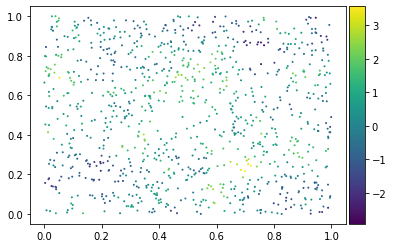

In [51]:

gp.plot(dat,size=1)

In [52]:
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 3
Maximum Number of UIDs       = 3
Total number of samples      = 1000

Variables
---------
Column = 0 - Name = x - Locator = x1
Column = 1 - Name = y - Locator = x2
Column = 2 - Name = spde.simu - Locator = z1

In [53]:
spdeRes = gl.SPDE()
spdeRes.init(model,grid,dat,gl.ESPDECalcMode.KRIGING,mesh)
spdeRes.compute()
spdeRes.query(grid)
spdeRes.computeQuad()

985.9966594697444

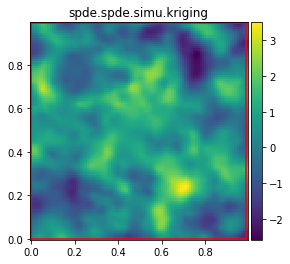

In [54]:
gp.plot(grid)

In [55]:
from scipy.optimize import minimize
mesh = gl.MeshETurbo(gridExt)
class storage :
    def __init__(self):
        pass
            
    def f(self,x) :
        print(x**2)
        self.model = gl.Model.createFromParam(gl.ECov.BESSEL_K,param=1,
                                              range=x[0]**2,
                                              sill=x[1]**2)
        self.model.addCovFromParam(gl.ECov.NUGGET,sill=x[2]**2)
        self.spde = gl.SPDE()
        self.spde.init(self.model,grid,dat,gl.ESPDECalcMode.KRIGING,mesh)
        self.spde.compute()
        res = -self.spde.computeLogLike(10,12134)
        print(res)
        return res
    

In [56]:
A = storage()
trueParams = np.array([np.sqrt(rangev),np.sqrt(sill),np.sqrt(nugget)])
print(trueParams**2)
A.f(trueParams)


[0.2 1.  0.1]
[0.2 1.  0.1]
94.26546923603928


94.26546923603928

In [58]:
bnds = ((0.0001, 2), (0.0001, 2),(0.1,2))

def cb(xk):
    print("-----------------------------------------------------")
    print(xk**2)
    
    
paramsInit = np.sqrt([0.5,0.5,0.5])
res = minimize(A.f, paramsInit,callback=cb,method="BFGS")


[0.5 0.5 0.5]
656.6805627579924
[0.50000002 0.5        0.5       ]
656.680603365917
[0.5        0.50000002 0.5       ]
656.6805573634599
[0.5        0.5        0.50000002]
656.6805707328328
[0.07598182 0.70167458 0.26430621]
331.2608338809635
[0.07598181 0.70167458 0.26430621]
331.2608065333796
[0.07598182 0.70167461 0.26430621]
331.26083430309376
[0.07598182 0.70167458 0.26430622]
331.26084393780883
-----------------------------------------------------
[0.07598182 0.70167458 0.26430621]
[0.08295111 1.10326333 0.25243711]
313.32773620839123
[0.0829511  1.10326333 0.25243711]
313.3277175711236
[0.08295111 1.10326336 0.25243711]
313.3277393038859
[0.08295111 1.10326333 0.25243709]
313.3277267574391
[7.93079307e-02 8.84236296e-01 5.47267085e-04]
161.03666203463456
[7.93079223e-02 8.84236296e-01 5.47267085e-04]
161.0365352224385
[7.93079307e-02 8.84236324e-01 5.47267085e-04]
161.03594278759817
[7.93079307e-02 8.84236296e-01 5.47267783e-04]
161.03666203463456
[0.08271246 1.08833101 0.219346

152.49604686022417
[0.0804175  0.94897158 0.01907854]
152.49620799322292
[0.08041749 0.94897158 0.01907854]
152.49597172953702
[0.0804175  0.94897161 0.01907854]
152.49632284594406
[0.0804175  0.94897158 0.01907853]
152.4961175709642
[0.0804175  0.94897157 0.01907854]
152.49661719389388
[0.08041749 0.94897157 0.01907854]
152.49604212972912
[0.0804175  0.9489716  0.01907854]
152.4958544034065
[0.0804175  0.94897157 0.01907853]
152.49612094219327
[0.0804175  0.94897157 0.01907854]
152.49606429979207
[0.08041749 0.94897157 0.01907854]
152.49627458255122
[0.0804175  0.9489716  0.01907854]
152.49591096454367
[0.0804175  0.94897157 0.01907853]
152.49617737674805
[0.0804175  0.94897157 0.01907854]
152.4960461029704
[0.08041749 0.94897157 0.01907854]
152.49610180090974
[0.0804175  0.9489716  0.01907854]
152.49649505569897
[0.0804175  0.94897157 0.01907853]
152.4961495219349
-----------------------------------------------------
[0.0804175  0.94897157 0.01907854]
[0.08042546 0.94904276 0.0191234

In [48]:
res.x**2

array([0.11987627, 1.87121872, 0.13509992])

In [13]:
import scipy as sc
from scipy.sparse import *
from scipy.sparse.linalg import *
import numpy as np

Qtr = gl.csToTriplet(spdeRes.getPrecisionOp().getQ())
Pgl = gl.ProjMatrix(dat,mesh)
Apgl = Pgl.getAproj()
Atr = gl.csToTriplet(Apgl)
Q = sc.sparse.csc_matrix((np.array(Qtr.values), (np.array(Qtr.rows), np.array(Qtr.cols))))
Aproj = sc.sparse.csc_matrix((np.array(Atr.values), (np.array(Atr.rows), np.array(Atr.cols))),
                         shape=(Atr.nrows,Atr.ncols))

In [14]:
Qchol = np.linalg.cholesky(Q.toarray())
u = np.random.normal(size = Q.shape[0])
b = Q @ u
print(np.max(np.abs(np.linalg.solve(Qchol.T,np.linalg.solve(Qchol,b)) - u)))

Qop = Q + 1/nugget * Aproj.T @ Aproj
cholQop = np.linalg.cholesky(Qop.toarray())
def solveMat(cholQop,x):
    return np.linalg.solve(cholQop.T,np.linalg.solve(cholQop,x))

def invSigma(sigma2,Aproj,cholQop,x):
    return 1./sigma2 * (x - 1./sigma2 * Aproj @ solveMat(cholQop, Aproj.T @ x))

def detQ(cholQ):
    return 2 * np.sum(np.log(np.diag(cholQ)))
x = dat["spde.simu"]
ones = np.ones_like(x)
invSigmaOnes = invSigma(nugget,Aproj,cholQop,ones)
mu  = np.sum(x * invSigmaOnes)/np.sum( ones * invSigmaOnes) *0
quad = np.sum((x-mu)*invSigma(nugget,Aproj,cholQop,x-mu))


logdet = len(x) * np.log(nugget) - detQ(Qchol) + detQ(cholQop)


3.9057646006313007e-13


In [15]:
mu  = np.sum(x * invSigmaOnes)/np.sum( ones * invSigmaOnes) *0
quad = np.sum((x-mu)*invSigma(nugget,Aproj,cholQop,x-mu))
quad

1118.7670103068613

In [17]:
print(-0.5 * (quad + logdet))
print("logdet",logdet)
print("quad",quad)
print("quad API",spdeRes.computeQuad())
#spdeRes = gl.SPDE()


168.09306084737227
logdet -1454.9531320016058
quad 1118.7670103068613
quad API 1118.7670681961386


In [20]:
spdeRes.init(model,grid,dat,gl.ESPDECalcMode.KRIGING,mesh)
spdeRes.compute()
spdeRes.computeLogLike(100)
#spdeRes.getCoeffs()

172.00393590752037

In [14]:
spdeRes.computeLogDet()


-853.2024297528792

In [93]:
x= [np.random.uniform(size=mesh.getNApices())]
y= gl.VectorVectorDouble(1)
y[0] = gl.VectorDouble(mesh.getNApices())
pm.evalInverse(x,y)

work2 = gl.VectorDouble(mesh.getNApices())

work3 = gl.VectorVectorDouble(1)
work3[0] = gl.VectorDouble(mesh.getNApices())

work1bis = gl.VectorDouble(ndat)

AprojOp = pm.getProjMatrix()
x= np.random.uniform(size=ndat)
result = x.copy()
for i in range(len(result)):
    result[i] /= nugget


AprojOp.point2mesh(result,work2)
pm.evalInverse([work2],work3)
AprojOp.mesh2point(work3[0],work1bis)
res = result - 1/nugget* np.array(work1bis)
np.sum((result - res))

5000.735695505086

In [120]:
x = gl.VectorDouble(ndat)
gl.ut_vector_simulate_gaussian_inplace(x)
y = gl.VectorDouble(ndat)
xc = np.array(x).copy()
pm.evalInvCov(x,y)
gl.ut_vector_inner_product(x,y)

6430.761680691854

In [121]:
pm.computeQuadratic(x)

-3883.582426842844

In [114]:
np.sum(res*x)

83.36834654653595

In [122]:
mu=0
ones = np.ones_like(x)
invSigmaOnes = invSigma(nugget,Aproj,cholQop,ones)
mu  = np.sum(x * invSigmaOnes)/np.sum( ones * invSigmaOnes) *0
quad = np.sum((x-mu)*invSigma(nugget,Aproj,cholQop,x-mu))
quad

6430.761690631395

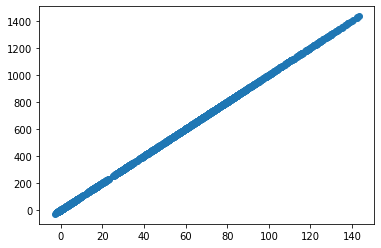

In [20]:
plt.scatter(y,solveMat(cholQop,x[0]))

In [ ]:
plt.scatter(np.array(y)*nugget,invSigma(sill,Aproj,cholQop,x))
plt.plot([0,0.5],[0,0.5])

In [ ]:
invSigma(sill,Aproj,cholQop,x)

In [ ]:
[pm.getVarianceData(i) for i in range(ndat)]